Given a table of observations of anonymized health characteristics as columns, the goal is to predict whether an observation leads to a positive diagnosis.

# Dependencies

In [1]:
import os
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if not is_kaggle:
    !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    !pip install -q pandas numpy matplotlib seaborn fastai
    !pip install -q kaggle


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# prettier plots
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Prep

In [3]:
competition_name = "icr-identify-age-related-conditions"

if is_kaggle:
    input_path = Path(f"/kaggle/input/{competition_name}")
else:
    input_path = Path.home() / ".kaggle" / "input" / competition_name
    !kaggle competitions download -p {input_path.parent} {competition_name}
    !unzip -o {input_path}.zip -d {input_path}

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /home/krm/.kaggle/input/icr-identify-age-related-conditions.zip
  inflating: /home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv  
  inflating: /home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv  
  inflating: /home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv  
  inflating: /home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv  


In [4]:
list(input_path.iterdir())

[PosixPath('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),
 PosixPath('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),
 PosixPath('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),
 PosixPath('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [5]:
train_df = pd.read_csv(input_path / "train.csv")
train_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

We have a columns `Id`, unique identifier for the observation, followed by 56 anonymized health characteristics and the predictions `Class`, where 1 is positive and 0 is negative.

In [7]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


The mean value of Class much closer to zero, which means that we have more observations classified as negative than positive.

<Axes: ylabel='count'>

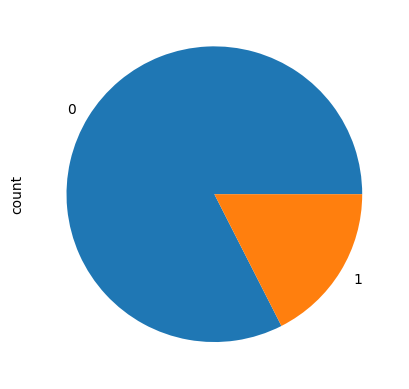

In [8]:
train_df.Class.value_counts().plot(kind="pie")

We can show the null values by column:

In [9]:
na_col_count = train_df.isna().sum()
na_col_count = na_col_count[na_col_count > 0]
na_col_count

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

To take care of null values, we'll replace them with the mode of each column. 

In [10]:
mode = train_df.BQ.mode()[0]
train_df.BQ.fillna(mode).isna().sum()

0

We'll also add a separate column for each of them with a boolean indicating whether the original value was null. This may be useful in the case where a null value is a useful predictor. The new columns will have data like below:

In [11]:
train_df.BQ.isna().astype('int')

0      0
1      0
2      0
3      0
4      0
      ..
612    0
613    0
614    0
615    1
616    0
Name: BQ, Length: 617, dtype: int64

We take a look at the non-numeric columns:

In [12]:
train_df.describe(include=[object])

,Id,EJ
count,617,617
unique,617,2
top,000ff2bfdfe9,B
freq,1,395


Since we'll be doing multiplication by parameters of the model, we need all inputs as numeric values. We typically treat non-numeric types as categorical variables, replacing them with additional columns for each unique value in the category. Each row will have a boolean value indicating which category it's value belongs to.

`Id` has too many values to be broken out into multiple categories and should be unique per observation, so we'll exclude it. We can get categories for the EJ column as with pandas method `get_dummies` as below:

In [13]:
train_df.EJ[:5]

0    B
1    A
2    B
3    B
4    B
Name: EJ, dtype: object

In [14]:
dummies_df = pd.get_dummies(train_df, columns=['EJ'])
dummies_df[['EJ_A', 'EJ_B']][:5]

,EJ_A,EJ_B
0,False,True
1,True,False
2,False,True
3,False,True
4,False,True


`get_dummies` will replace the original `EJ` column with two columns for each possible value. The boolean values can then be converted to integers.

However, since there are only two possible values for EJ, a second column will be a duplicate of the same information since they're mutually exclusive. We'll retain it as one column and use a boolean integer to distinguish between the two categories like below:

In [15]:
pd.Categorical(train_df.EJ).codes[:10]

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0], dtype=int8)

Looking at the float64 columns in the dataframe, some have quite a skewed distribution, i.e. a few rows with outlier values. For example in the column below, a few rows have really large values.

<Axes: xlabel='FR', ylabel='Density'>

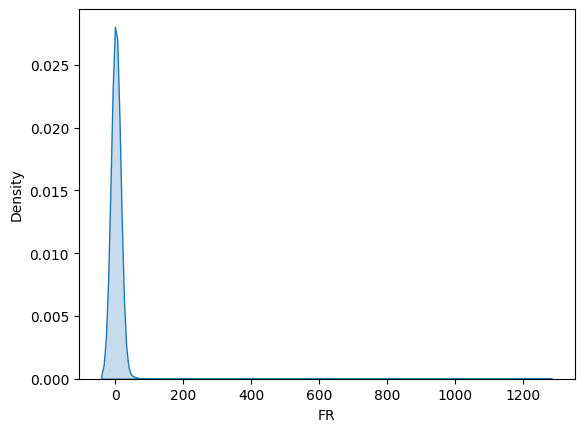

In [16]:
sns.kdeplot(data=train_df.FR, fill=True)

In [17]:
train_df.FR.min(), train_df.FR.mean(), train_df.FR.max()

(0.49706, 3.533905218800648, 1244.22702)

This will result in only a few rows with large values dominating the results. To avoid this, we replace their values with the log, resulting in a smaller range.

<Axes: xlabel='FR', ylabel='Density'>

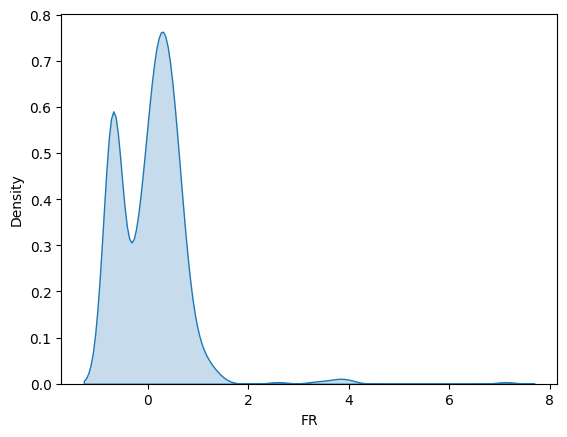

In [18]:
data = np.log(train_df.FR)
sns.kdeplot(data, fill=True)

In [19]:
data.min(), data.mean(), data.max()

(-0.6990445358260293, 0.06233208049973395, 7.126269748610907)

We now have a much smaller range from -0.6 to 7.1.

We can now combine all the transformations above and apply them on  the training and testing dataframes.

In [20]:
ycol = "Class"
categorical_col = "EJ"
continuous_cols = [c for c in train_df.columns if c not in [categorical_col, ycol, "Id"]]

test_df = pd.read_csv(input_path / "test.csv")
test_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def pre_process(df, modes, na_cols):
    df = df.drop(columns="Id")
    
    for col in na_cols:
        df[f'{col}_na'] = df[col].isna().astype('int')
        
    df = df.fillna(modes)
    
    df[categorical_col] = pd.Categorical(df[categorical_col]).codes 

    for col in continuous_cols:
        # add one, because np.log(0) is infinite
        df[col] = np.log(df[col] + 1)
    return df

modes = train_df.mode().iloc[0]
train_df1 = pre_process(train_df, modes, na_col_count.index)
test_df1 = pre_process(test_df, modes, na_col_count.index)

We need our independent and dependent variables as pytorch tensors. We'll extract the data from the dataframes. 

In [22]:
import torch
from torch import tensor

y = tensor(train_df1.Class)
y.shape

torch.Size([617])

In [23]:
data = train_df1[continuous_cols + [categorical_col]].values
X = tensor(data, dtype=torch.float)
X.shape

torch.Size([617, 56])

We can print the first 3 input rows and predictions as below:

In [24]:
print(X[:3])
print(y[:3])

tensor([[1.9011e-01, 8.0424e+00, 4.4567e+00, 3.1525e+00, 2.2125e+00, 5.3055e-01,
         2.5256e-02, 2.3807e+00, 1.8803e+00, 8.3254e+00, 3.1612e+00, 5.1741e+00,
         5.0351e+00, 6.7153e+00, 5.5546e+00, 3.8758e+00, 4.4691e-01, 3.1941e+00,
         1.7668e+00, 2.3211e-02, 7.1795e-01, 6.6934e-02, 2.6936e+00, 8.3378e-01,
         3.6165e+00, 4.2497e+00, 5.6923e+00, 2.1405e-01, 2.5016e-01, 4.5025e+00,
         4.4464e+00, 3.4229e+00, 1.8422e+00, 1.0091e+00, 3.1858e+00, 2.1156e+00,
         1.0944e+00, 7.2683e+00, 6.6737e-01, 3.4620e+00, 4.3761e+00, 1.5745e+00,
         2.6669e+00, 2.4217e+00, 9.1082e+00, 1.5225e+00, 2.1160e+00, 1.0074e+00,
         9.0592e-02, 2.5128e+00, 4.2988e+00, 7.6033e+00, 3.1414e+00, 4.2604e+00,
         1.1363e-01, 1.0000e+00],
        [1.3565e-01, 6.8873e+00, 4.4567e+00, 3.6368e+00, 2.2125e+00, 1.5330e+00,
         2.5256e-02, 2.6754e+00, 8.0196e-01, 8.6121e+00, 3.0165e+00, 5.0554e+00,
         2.7571e+00, 3.9554e+00, 5.5546e+00, 3.4431e+00, 3.9522e-01, 3.9441

# Fit Model

## Linear Model

We'll start with simple linear model, for which we need coefficients for each input feature and a bias as our parameters. We initialize the parameters as random numbers centered around 0:

In [25]:
torch.manual_seed(42)
n_coeff = X.shape[1]

coeffs = torch.rand(n_coeff) - 0.5
bias = torch.rand(1) - 0.5
coeffs, bias

(tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009, -0.2434,  0.2936,
          0.4408, -0.3668,  0.4346,  0.0936,  0.3694,  0.0677,  0.2411, -0.0706,
          0.3854,  0.0739, -0.2334,  0.1274, -0.2304, -0.0586, -0.2031,  0.3317,
         -0.3947, -0.2305, -0.1412, -0.3006,  0.0472, -0.4938,  0.4516, -0.4247,
          0.3860,  0.0832, -0.1624,  0.3090,  0.0779,  0.4040,  0.0547, -0.1577,
          0.1343, -0.1356,  0.2104,  0.4464,  0.2890, -0.2186,  0.2886,  0.0895,
          0.2539, -0.3048, -0.4950, -0.1932, -0.3835,  0.4103,  0.1440,  0.2071]),
 tensor([0.1581]))

We'd get our initial predictions from the linear model as shown below:

In [26]:
preds = (X * coeffs).sum(dim=1) + bias
preds.shape

torch.Size([617])

However, the columns with relatively larger values are likely to dominate the results. Getting the average column values, we can see that there's quite a variation:

In [27]:
X.sum(axis=0) / X.shape[0]

tensor([0.3612, 7.9640, 4.6529, 3.2092, 2.3232, 1.8221, 0.0456, 2.3701, 1.3394,
        8.5203, 3.0967, 5.3208, 4.2660, 6.3931, 5.8539, 3.8312, 0.5143, 4.4070,
        2.2376, 0.0301, 0.8093, 0.5437, 3.5791, 0.8437, 3.1281, 3.8712, 5.7427,
        0.3634, 0.3093, 4.8944, 4.5125, 3.2673, 0.5106, 1.0411, 3.0968, 2.2275,
        1.2954, 7.2820, 0.1663, 4.1095, 4.5880, 3.0390, 3.7811, 1.1472, 8.9723,
        2.3728, 1.2481, 0.7731, 0.2892, 2.9911, 4.6552, 8.8071, 3.4352, 3.6830,
        1.3632, 0.6402])

We can scale all columns to values between 0 and 1 by dividing each column with it's maximum value. The average column values then have much less variation.

In [28]:
max_vals, _ = X.max(axis=0)
(X / max_vals).sum(0) / X.shape[0]

tensor([0.1835, 0.7759, 0.6158, 0.4977, 0.4474, 0.4964, 0.0188, 0.6426, 0.1837,
        0.7832, 0.9077, 0.6819, 0.7298, 0.5285, 0.5409, 0.4957, 0.3155, 0.6829,
        0.4215, 0.1487, 0.2321, 0.3894, 0.6398, 0.4730, 0.7479, 0.7231, 0.7505,
        0.0993, 0.4279, 0.7036, 0.7793, 0.7862, 0.1003, 0.3188, 0.6153, 0.4881,
        0.4374, 0.7058, 0.0441, 0.8741, 0.6582, 0.3461, 0.4716, 0.1558, 0.7557,
        0.6579, 0.2530, 0.1085, 0.0832, 0.6081, 0.6366, 0.7416, 0.7791, 0.7004,
        0.4349, 0.6402])

We therefore scale down our X values:

In [29]:
X = X / max_vals

This is how we can get our initial set of predictions:

In [30]:
preds = (X * coeffs).sum(axis=1) + bias
preds[:10]

tensor([1.3688, 0.3260, 1.1451, 1.1732, 0.9525, 0.4920, 1.0112, 0.7388, 0.9440,
        0.6490])

For the linear model to learn, it needs to evaluate its predictions at each step to see how far it is from the true predictions, and modify its parameters to give better predictions.

One simple way to do this is to get the mean error across all the predictions by calculating the mean absolute error like below:

In [31]:
torch.abs(preds-y).mean()

tensor(0.7565)

The mean absolute error will therefore be the loss function that will be used improve predictions.

We add functions to calculate predictions and the loss as shown above. 

In [32]:
def calculate_preds(coeffs, bias, X): return (X * coeffs).sum(axis=1) + bias
def calculate_loss(coeffs, bias, X, y): return torch.abs(calculate_preds(coeffs, bias, X) - y).mean()

In [33]:
calculate_loss(coeffs, bias, X, y)

tensor(0.7565)

It gives us the same MAE as seen previously.

Now that we have a means of getting predictions and evaluating them via the loss function, we now need a way of using the loss to alter the parameters (coefficients + bias) to improve the next set of predictions. We do this by getting the gradient of each parameter after calculating the loss. We need to intialize the parameters in a special way to achieve this.

In [34]:
coeffs.requires_grad_(), bias.requires_grad_()
coeffs, bias

(tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009, -0.2434,  0.2936,
          0.4408, -0.3668,  0.4346,  0.0936,  0.3694,  0.0677,  0.2411, -0.0706,
          0.3854,  0.0739, -0.2334,  0.1274, -0.2304, -0.0586, -0.2031,  0.3317,
         -0.3947, -0.2305, -0.1412, -0.3006,  0.0472, -0.4938,  0.4516, -0.4247,
          0.3860,  0.0832, -0.1624,  0.3090,  0.0779,  0.4040,  0.0547, -0.1577,
          0.1343, -0.1356,  0.2104,  0.4464,  0.2890, -0.2186,  0.2886,  0.0895,
          0.2539, -0.3048, -0.4950, -0.1932, -0.3835,  0.4103,  0.1440,  0.2071],
        requires_grad=True),
 tensor([0.1581], requires_grad=True))

This results in a tensor with `requires_grad` set to `True`. After we calculate the loss, we use pytorch's inbuilt functionality to calculate the gradients for each parameter:

In [35]:
loss = calculate_loss(coeffs, bias, X, y)
loss

tensor(0.7565, grad_fn=<MeanBackward0>)

In [36]:
loss.backward()

Now we can see the gradients per parameter:

In [37]:
coeffs.grad, bias.grad

(tensor([0.1567, 0.6927, 0.5511, 0.4441, 0.3996, 0.4430, 0.0141, 0.5748, 0.1580,
         0.7024, 0.8117, 0.6109, 0.6501, 0.4746, 0.4841, 0.4478, 0.2880, 0.6078,
         0.3762, 0.1326, 0.2071, 0.3587, 0.5756, 0.4314, 0.6708, 0.6537, 0.6786,
         0.0834, 0.3879, 0.6260, 0.7039, 0.7055, 0.0961, 0.2853, 0.5433, 0.4367,
         0.4018, 0.6324, 0.0431, 0.7754, 0.5901, 0.3043, 0.4202, 0.1487, 0.6747,
         0.5915, 0.2390, 0.0950, 0.0766, 0.5454, 0.5733, 0.6641, 0.6969, 0.6295,
         0.3592, 0.6078]),
 tensor([0.8963]))

When we called `requires_grad_` on the parameters, we signal to pytorch to record the operations that the parameters are involved in. When we call `backward` on the loss, pytorch calculates the partial derivative of each parameter, i.e. the derivative of the combined sequence of operations for each parameter given that all the others held constant.

Let's repeat the steps:

In [38]:
loss = calculate_loss(coeffs, bias, X, y)
loss.backward()
loss, coeffs.grad, bias.grad

(tensor(0.7565, grad_fn=<MeanBackward0>),
 tensor([0.3133, 1.3855, 1.1021, 0.8882, 0.7992, 0.8859, 0.0281, 1.1496, 0.3159,
         1.4048, 1.6233, 1.2219, 1.3001, 0.9491, 0.9683, 0.8957, 0.5761, 1.2156,
         0.7524, 0.2652, 0.4141, 0.7174, 1.1512, 0.8629, 1.3416, 1.3074, 1.3571,
         0.1667, 0.7759, 1.2520, 1.4078, 1.4111, 0.1922, 0.5707, 1.0866, 0.8734,
         0.8035, 1.2648, 0.0862, 1.5508, 1.1802, 0.6086, 0.8405, 0.2974, 1.3494,
         1.1831, 0.4779, 0.1899, 0.1531, 1.0907, 1.1466, 1.3282, 1.3938, 1.2590,
         0.7183, 1.2156]),
 tensor([1.7925]))

We notice that the gradients have doubled. This is because pytorch repeated the same order of operations and calculated the gradients as we had earlier, but then added them the the earlier gradients. So we have to be careful each time we use the gradients to update the parameters, to zero them afterward so that we get a new set of gradients after the next iteration.

In [39]:
coeffs.grad.zero_(), bias.grad.zero_()
coeffs.grad, bias.grad

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0.]))

We now run the iterations a few times. Notice the loss decreasing with every iteration:

In [40]:
for _ in range(3):
    loss = calculate_loss(coeffs, bias, X, y)
    print(loss)
    loss.backward()
    with torch.no_grad():
        # will not include the operations in this block
        # in calculating the next set of gradients
        coeffs.sub_(coeffs.grad * 0.01)
        bias.sub_(bias.grad * 0.01)
        coeffs.grad.zero_()
        bias.grad.zero_()

tensor(0.7565, grad_fn=<MeanBackward0>)
tensor(0.6127, grad_fn=<MeanBackward0>)
tensor(0.4945, grad_fn=<MeanBackward0>)


The goal is to minimize the error with each training cycle through the data, i.e. each epoch. This translates to moving the parameters in the direction opposite of the gradient at a point on the graph that can be plotted for the function that combines all the operations involved in calculating the loss.

If the gradient is positive, meaning that the slope's direction on the graph at that point is upwards, we want to move backwards. If the gradient is negative, meaning that the direction is downwards, we want to move forward, because we want to find the minimum point in the graph. This is achieved by subtracting each gradient from its parameter.

However, there's a risk that we might subtract too much and overshoot the minimum point. So we scale down the gradient by a factor before subtracting it from the parameter. This becomes our `learning_rate`.

# Inference